# Bayesian neural network

First, we load the modules we need:

In [1]:
import jax.numpy as jnp
import jax
from jaxtyping import Array, Float
from dataclasses import dataclass

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import distrax as dx
from scipy.spatial.distance import pdist, squareform

from coinem.model import AbstractModel
from coinem.dataset import Dataset

# Pyplot for plots.
import matplotlib.pyplot as plt 

from jax import vmap

from tqdm import tqdm

## Model

We now setup the model.

In [2]:
@dataclass
class BayesNN(AbstractModel):
    """Base class for p(θ, x)."""
    
    def log_prob(self, latent: Float[Array, "D"], theta: Float[Array, "Q"], data: Dataset) -> Float[Array, ""]:
        """Compute gradient of the objective function at x.

        Args:
            latent (Float[Array, "D"]): Input weights of shape (D,).
            theta (Float[Array, "Q"]): Parameters of shape (2,).

        Returns:
            Float[Array, ""]: log-probability of the data.
        """
        X = data.X # [Batchsize, 28, 28]
        y = data.y # [Batchsize, 1]

        # Compute prior:
        log_prior_w = dx.Normal(0.0, jnp.exp(1.0 * theta["alpha"].squeeze())).log_prob(latent["w"].ravel()).sum()
        log_prior_v = dx.Normal(0.0, jnp.exp(1.0 * theta["beta"].squeeze())).log_prob(latent["v"].ravel()).sum()


        def _log_nn(image):
            # Log of the network's output when evaluated at image with weights w, v.
            return jax.nn.log_softmax(jnp.dot(latent["v"], jnp.tanh(jnp.dot(latent["w"], image.flatten())))) 


        def _log_nn_vec(images):
            # _log_nn vectorized over particles.
            return jax.vmap(_log_nn)(images)


        def _log_likelihood(images, labels):
            # Log-likelihood for set of images and labels, vectorized over particles.
            return vmap(lambda v, l : v[l])(_log_nn_vec(images), labels).sum()

        return  (_log_likelihood(X, y) + log_prior_w + log_prior_v) / data.n # log p(y|x) + log p(x|theta) 
    

    def optimal_theta(self, latent_particles: Float[Array, "N D *"]) -> Float[Array, "Q *"]:
        """Optimal parameter for weight cloud w."""
        mom2 = (jax.vmap(_normsq)(latent_particles["w"])).mean()  # Second moment
        mom4 = (jax.vmap(_normsq)(latent_particles["v"])).mean()  # Fourth moment


        return {"alpha": jnp.log(mom2/(latent_particles["w"][0].size))/2, 
                "beta": jnp.log(mom4/(latent_particles["v"][0].size))/2}
    


def _normsq(x):
    # Squared Frobenius norm of x.
    v = x.reshape((x.size))
    return jnp.dot(v, v)

Next, we load and curate the dataset:

In [3]:
#@title Load, subsample, and normalize MNIST dataset.
import numpy as np

# Load dataset:
from keras.datasets import mnist
(images, labels), _ = mnist.load_data()
images = np.array(images).astype(float)
labels = np.array(labels).astype(int)

# Keep only datapoints with labels 4 and 9:
indices = (labels == 4) | (labels == 9)
labels = labels[indices]
images = images[indices, :, :]

# Relabel as 4 as 0 and 9 as 1:
for n in range(labels.size):
    if labels[n] == 4:
        labels[n] = 0
    else:
        labels[n] = 1

# Sub-sample 1000 images:
from sklearn.model_selection import train_test_split
images, _, labels, _ = train_test_split(images, labels, train_size=1000,
                                        random_state=0)

# Normalize non-zero entries so that they have mean zero and unit standard 
# across the dataset:'''
i = images.std(0) != 0
images[:, i] = (images[:, i] - images[:, i].mean(0))/images[:, i].std(0)

# Split data into 80/20 training and testing sets:
itrain, itest, ltrain, ltest = train_test_split(images, labels, test_size=0.2,
                                                random_state=1)

from coinem.dataset import Dataset

data = Dataset(jnp.array(itrain), jnp.array(ltrain).reshape(-1, 1))


We then implement the algorithms. They take in the following inputs:

*   itrain : training set labels,
*   itrain : training set images,
*   itest : test set labels,
*   itest : test set images,
*   h : step-size,
*   K : number of steps,
*   N : number of particles,
*   a : 1-dimensional vector with initial alpha guess,
*   b : 1-dimensional vector with initial beta guess,
*   w : Dw x N matrix storing the input layer weights of the initial particle cloud,
*   v : Dv x N matrix storing the output layer weights of the initial particle cloud.

They return the following outputs:

*   a : K-dimensional vector of alpha estimates,
*   b : K-dimensional vector of beta estimates,
*   w : Dw x N matrix storing the input layer weights of the final particle cloud,
*   v : Dv x N matrix storing the output layer weights of the final particle cloud,
*   lppd : log pointwise predictive density (LPPD) as a function of k,
*   error : test error as a function of k.

We can now run the algorithms using an 80/20 training/test split of the data:

In [4]:
K = 500 # Number of steps.
N = 10  # Number of particles.

key = jr.PRNGKey(2)

alpha = jnp.array(0.0)
beta = jnp.array(0.0)

# Initialize particle cloud by sampling prior:'
w_init = jnp.exp(alpha) * jr.normal(key, (N, 40, 28**2))  # Input layer weights.
v_init = jnp.exp(beta) * jr.normal(key, (N, 2, 40))  # Output layer weights.
theta_init = {"alpha": alpha, "beta": beta}
latent_init = {"w": w_init, "v": v_init}

from coinem.zoo import (
        coin_svgd,
        pgd,
        soul,
        adam_svgd,
        ada_svgd,
        rms_pgd,
        rms_soul,
        ada_pgd,
        ada_soul,
        adam_pgd,
        adam_soul,
        rms_svgd,
    )

model = BayesNN()

Let's setup the heuristic from Kuntz et al. (2023)

In [5]:
Dw = w_init[0,:,:].size
Dv = v_init[0,:,:].size

from coinem.expectation_maximisation import (
    expectation_maximisation,
    )

from coinem.maximisation_step import GradientMaximisationState, MaximisationStep
from coinem.expectation_step import (
    ParticleGradientExpectationStep,
    SoulExpectationStep,
    SteinExpectationStep,
)

from coinem.gradient_transforms import GradientTransformation
from coinem.zoo import svgd

from typing import Tuple
from jaxtyping import Float, Array
import jax.tree_util as jtu

class HeuristicMaximisationState(MaximisationStep):
        def update(
            self,
            maximisation_state: GradientMaximisationState,
            latent: Float[Array, "N D"],
            theta: Float[Array, "Q"],
            data: Dataset,
        ) -> Tuple[Float[Array, "Q"], GradientMaximisationState]:
            
            # Unpack maximisation state
            theta_opt_state = maximisation_state.optimiser_state

            # Find negative average score of theta, since we are maximising, but optimisers minimise.
            average_score_theta = self.model.average_score_theta(
                latent, theta, data
            )

            # Kuntz Heuristic: divide by dimension of parameter space for the latent component
            average_score_theta["alpha"] = average_score_theta["alpha"] / Dw
            average_score_theta["beta"] = average_score_theta["beta"] / Dv

            negative_average_score_theta = jtu.tree_map(
                lambda x: -x, average_score_theta
            )

            # Find update rule for theta
            theta_updates, theta_new_opt_state = self.optimiser.update(
                negative_average_score_theta, theta_opt_state, theta
            )

            # Apply updates to theta
            theta_new = jtu.tree_map(lambda p, u: p + u, theta, theta_updates)

            # Update maximisation state
            maximisation_state_new = GradientMaximisationState(
                optimiser_state=theta_new_opt_state
            )

            return theta_new, maximisation_state_new

In [7]:
from jax.random import KeyArray
import optax as ox

def heuristic_pgd(
    model: AbstractModel,
    data: Dataset,
    latent_init: Float[Array, "N D"],
    theta_init: Float[Array, "Q"],
    num_steps: int,
    latent_step_size: float = 1e-2,
    theta_step_size: float = 1e-2,
    batch_size: int = -1,
    key: KeyArray = jr.PRNGKey(42),
) -> Tuple[Float[Array, "K N D"], Float[Array, "K Q"]]:
    """Perform the Particle Gradient Descent algorithm.

    Args:
        model (AbstractModel): The model.
        data (Dataset): The dataset.
        latent_init (Float[Array, "N D"]): The initial latent particles.
        theta_init (Float[Array, "Q"]): The initial parameters.
        num_steps (int): The number of steps to perform, K.
        latent_step_size (float, optional): The latent step size. Defaults to 1e-2.
        theta_step_size (float, optional): The parameter step size. Defaults to 1e-2.
        batch_size (int, optional): The batch size. Defaults to -1.
        key (KeyArray, optional): The random key. Defaults to jr.PRNGKey(42).

    Returns:
        Tuple[Float[Array, "K N D"], Float[Array, "K Q"]]: The latent particles and parameters.
    """
    return expectation_maximisation(
        expectation_step=ParticleGradientExpectationStep(
            model=model, step_size=latent_step_size
        ),
        maximisation_step=HeuristicMaximisationState(
            model=model, optimiser=ox.sgd(theta_step_size)
        ),
        data=data,
        latent_init=latent_init,
        theta_init=theta_init,
        num_steps=num_steps,
        batch_size=batch_size,
        key=key,
    )

def heuristic_soul(
    model: AbstractModel,
    data: Dataset,
    latent_init: Float[Array, "N D"],
    theta_init: Float[Array, "Q"],
    num_steps: int,
    latent_step_size: float = 1e-2,
    theta_step_size: float = 1e-2,
    batch_size: int = -1,
    key: KeyArray = jr.PRNGKey(42),
):
    """Perform the SoulEM algorithm.

    Args:
        model (AbstractModel): The model.
        data (Dataset): The dataset.
        latent_init (Float[Array, "N D"]): The initial latent particles.
        theta_init (Float[Array, "Q"]): The initial parameters.
        num_steps (int): The number of steps to perform, K.
        latent_step_size (float, optional): The latent step size. Defaults to 1e-2.
        theta_step_size (float, optional): The parameter step size. Defaults to 1e-2.
        batch_size (int, optional): The batch size. Defaults to -1.
        key (KeyArray, optional): The random key. Defaults to jr.PRNGKey(42).

    Returns:
        Tuple[Float[Array, "K N D"], Float[Array, "K Q"]]: The latent particles and parameters.
    """

    return expectation_maximisation(
        expectation_step=SoulExpectationStep(
            model=model, step_size=latent_step_size
        ),
        maximisation_step=HeuristicMaximisationState(
            model=model, optimiser=ox.sgd(theta_step_size)
        ),
        data=data,
        latent_init=latent_init,
        theta_init=theta_init,
        num_steps=num_steps,
        batch_size=batch_size,
        key=key,
    )


def heuristic_svgd(
    model: AbstractModel,
    data: Dataset,
    latent_init: Float[Array, "N D"],
    theta_init: Float[Array, "Q"],
    latent_optimiser: GradientTransformation,
    theta_optimiser: GradientTransformation,
    num_steps: int,
    batch_size: int = -1,
    key: KeyArray = jr.PRNGKey(42),
) -> Tuple[Float[Array, "K N D"], Float[Array, "K Q"]]:
    """
    Perform the Stein variational gradient descent EM algorithm.

    Args:
        model (AbstractModel): The model.
        data (Dataset): The dataset.
        latent_init (Float[Array, "N D"]): The initial latent particles.
        theta_init (Float[Array, "Q"]): The initial parameters.
        latent_optimiser (GradientTransformation): The latent optimiser.
        theta_optimiser (GradientTransformation): The parameter optimiser.
        num_steps (int): The number of steps to perform, K.
        batch_size (int, optional): The batch size. Defaults to -1.
        key (KeyArray, optional): The random key. Defaults to jr.PRNGKey(42).

    Returns:
        Tuple[Float[Array, "K N D"], Float[Array, "K Q"]]: The latent particles and parameters.
    """

    return expectation_maximisation(
        expectation_step=SteinExpectationStep(
            model=model, optimiser=latent_optimiser
        ),
        maximisation_step=HeuristicMaximisationState(
            model=model, optimiser=theta_optimiser
        ),
        data=data,
        latent_init=latent_init,
        theta_init=theta_init,
        num_steps=num_steps,
        batch_size=batch_size,
        key=key,
    )

def standard_heuristic_svgd(
    model: AbstractModel,
    data: Dataset,
    latent_init: Float[Array, "N D"],
    theta_init: Float[Array, "Q"],
    num_steps: int,
    latent_step_size: float = 1e-2,
    theta_step_size: float = 1e-2,
    batch_size: int = -1,
    key: KeyArray = jr.PRNGKey(42),
) -> Tuple[Float[Array, "K N D"], Float[Array, "K Q"]]:
    """Perform the Adam SVGD algorithm.

    Args:
        model (AbstractModel): The model.
        data (Dataset): The dataset.
        latent_init (Float[Array, "N D"]): The initial latent particles.
        theta_init (Float[Array, "Q"]): The initial parameters.
        num_steps (int): The number of steps to perform, K.
        latent_step_size (float, optional): The latent step size. Defaults to 1e-2.
        theta_step_size (float, optional): The parameter step size. Defaults to 1e-2.
        batch_size (int, optional): The batch size. Defaults to -1.
        key (KeyArray, optional): The random key. Defaults to jr.PRNGKey(42).

    Returns:
        Tuple[Float[Array, "K N D"], Float[Array, "K Q"]]: The latent particles and parameters.
    """

    latent_optimiser = ox.sgd(latent_step_size)
    theta_optimiser = ox.sgd(theta_step_size)

    return heuristic_svgd(
        model=model,
        data=data,
        latent_init=latent_init,
        theta_init=theta_init,
        latent_optimiser=latent_optimiser,
        theta_optimiser=theta_optimiser,
        num_steps=num_steps,
        batch_size=batch_size,
        key=key,
    )

In [8]:
# now we run the methods

x_pgd, theta_pgd = ada_pgd(model, data, latent_init.copy(), theta_init.copy(), K, latent_step_size=1e-2, theta_step_size=1e-2)
x_pgd_heuristic, theta_pgd_heuristic = heuristic_pgd(model,data,latent_init,theta_init,K,theta_step_size=1e1,latent_step_size=1e1)

x_coin, theta_coin = coin_svgd(model, data, latent_init, theta_init, K, alpha=100.0)

x_svgd, theta_svgd = ada_svgd(model, data, latent_init, theta_init, K, latent_step_size=0.8, theta_step_size=0.8)
x_svgd_heuristic, theta_svgd_heuristic = standard_heuristic_svgd(model, data, latent_init, theta_init, K, latent_step_size=1e1, theta_step_size=1e1)

x_soul, theta_soul = soul(model, data, latent_init.copy(), theta_init.copy(), K, latent_step_size=1e-2, theta_step_size=1e-2)
x_soul_heuristic, theta_soul_heuristic = heuristic_soul(model, data, latent_init.copy(), theta_init.copy(), K, latent_step_size=1e1, theta_step_size=1e1)

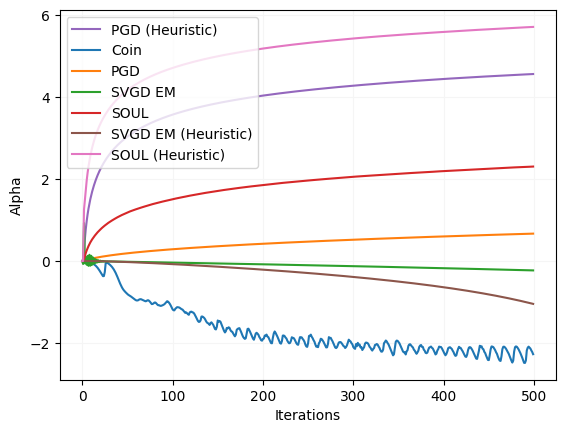

In [9]:
plt.plot(theta_pgd_heuristic["alpha"], color='C4', label="PGD (Heuristic)")
plt.plot(theta_coin["alpha"], label="Coin", color="C0")
plt.plot(theta_pgd["alpha"], label="PGD", color="C1")
plt.plot(theta_svgd["alpha"], label="SVGD EM", color="C2")
plt.plot(theta_soul["alpha"], label="SOUL", color="C3")
plt.plot(theta_svgd_heuristic["alpha"], label="SVGD EM (Heuristic)", color="C5")
plt.plot(theta_soul_heuristic["alpha"], label="SOUL (Heuristic)", color="C6")
plt.grid(color='whitesmoke')
plt.xlabel("Iterations")
plt.ylabel("Alpha")
plt.legend()
plt.show()

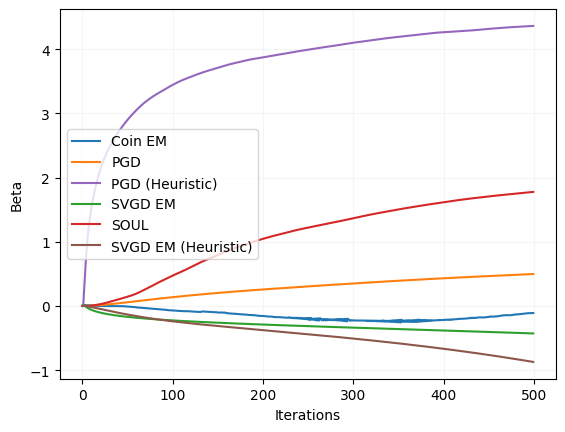

In [17]:
plt.plot(theta_coin["beta"], label="Coin EM", color="C0")
plt.plot(theta_pgd["beta"], label="PGD", color="C1")
plt.plot(theta_pgd_heuristic["beta"], label="PGD (Heuristic)", color="C4")
plt.plot(theta_svgd["beta"], label="SVGD EM", color="C2")
plt.plot(theta_soul["beta"], label="SOUL", color="C3")
plt.plot(theta_svgd_heuristic["beta"], label="SVGD EM (Heuristic)", color="C5")
plt.grid(color='whitesmoke')
plt.xlabel("Iterations")
plt.ylabel("Beta")
plt.legend()

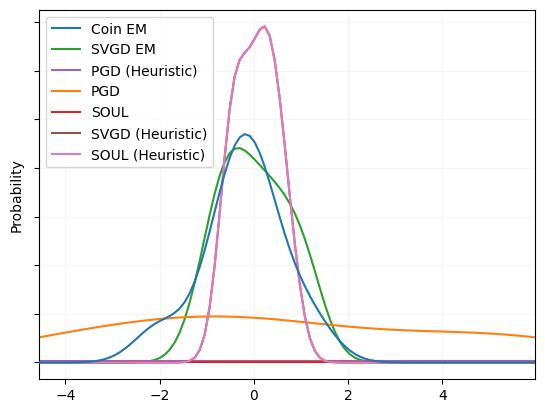

In [23]:
# Choose a random weight for the input layer:
oi = np.random.randint(0, v_init[0, :, 0].size)  # Output index.
ii = np.random.randint(0, v_init[0, 0, :].size)  # Input index.

# Generate KDEs:
from scipy import stats

kde_min = np.min([x_coin["v"][K, :, oi, ii], x_svgd["v"][K, :, oi, ii], x_pgd["v"][K, :, oi, ii]])
kde_max = np.max([x_coin["v"][K, :, oi, ii], x_svgd["v"][K, :, oi, ii], x_pgd["v"][K, :, oi, ii]])
xaxis = np.linspace(kde_min, kde_max, num=100)

kde_coin = stats.gaussian_kde(x_coin["v"][K, :, oi, ii])(xaxis)
kde_pgd = stats.gaussian_kde(x_pgd["v"][K, :, oi, ii])(xaxis)
kde_soul = stats.gaussian_kde(x_soul["v"][K, :, oi, ii])(xaxis)
kde_svgd = stats.gaussian_kde(x_svgd["v"][K, :, oi, ii])(xaxis)
kde_pgd_heuristic = stats.gaussian_kde(x_pgd_heuristic["v"][K, :, oi, ii])(xaxis)
kde_svgd_heuristic = stats.gaussian_kde(x_svgd_heuristic["v"][K, :, oi, ii])(xaxis)

# Plot KDEs:
fig,ax = plt.subplots(1)

plt.plot(xaxis, kde_coin, label='Coin EM', color='C0', zorder=10)
plt.plot(xaxis, kde_svgd, label='SVGD EM', color="C2")
plt.plot(xaxis, kde_pgd_heuristic, label='PGD (Heuristic)', color="C4")
plt.plot(xaxis, kde_pgd, label='PGD', color="C1")
plt.plot(xaxis, kde_soul, label='SOUL', color="C3")
plt.plot(xaxis, kde_svgd_heuristic, label='SVGD (Heuristic)', color="C5")
plt.plot(xaxis, kde_svgd_heuristic, label='SOUL (Heuristic)', color="C6")

#plt.ylim([0, 1.01*kde_soul.max()])
plt.xlim([kde_min, kde_max])
plt.grid(color='whitesmoke')
ax.set_ylabel('Probability')
ax.set_yticklabels([])
plt.legend(loc='upper left')
plt.show()

In [ ]:
def log_pointwise_predrictive_density(model, latent_particles, images, labels):
    """Returns LPPD for set of (test) images and labels."""

    def _latent_cal(latent):

        def _log_nn(image):
            # Log of the network's output when evaluated at image with weights w, v.
            return jax.nn.log_softmax(jnp.dot(latent["v"], jnp.tanh(jnp.dot(latent["w"], image.flatten())))) 


        def _log_nn_vec(images):
            # _log_nn vectorized over particles.
            return jax.vmap(_log_nn)(images)


        return _log_nn_vec(images)
    
    s = jax.vmap(_latent_cal)(latent_particles).mean(0)
    return vmap(lambda v, l : v[l])(s, labels).mean()




def _predict(model, latent_particles, images):
    """Returns LPPD for set of (test) images and labels."""

    def _latent_cal(latent):

        def _log_nn(image):
            # Log of the network's output when evaluated at image with weights w, v.
            return jax.nn.log_softmax(jnp.dot(latent["v"], jnp.tanh(jnp.dot(latent["w"], image.flatten()))))  


        def _log_nn_vec(images):
            # _log_nn vectorized over particles.
            return jax.vmap(_log_nn)(images)


        return _log_nn_vec(images)
    
    s = jax.vmap(_latent_cal)(latent_particles).mean(0)
    return jnp.argmax(s, axis=1)


def test_error(model, latent_particles, images, labels):
    """Returns fraction of misclassified images in test set."""
    return jnp.abs(labels.squeeze() - _predict(model, latent_particles, images)).mean()

In [ ]:
plt.plot(vmap(lambda p: log_pointwise_predrictive_density(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_coin), label="Coin EM", color="C0")
plt.plot(vmap(lambda p: log_pointwise_predrictive_density(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_pgd), label="PGD", color="C1")
plt.plot(vmap(lambda p: log_pointwise_predrictive_density(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_svgd), label="SVGD EM", color="C2")
plt.plot(vmap(lambda p: log_pointwise_predrictive_density(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_soul), label="SOUL", color="C3")
plt.plot(vmap(lambda p: log_pointwise_predrictive_density(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_pgd_heuristic), label="PGD (Heuristic)", color="C3")
plt.plot(vmap(lambda p: log_pointwise_predrictive_density(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_svgd_heuristic), label="SVGD EM (Heuristic)", color="C5")
plt.plot(vmap(lambda p: log_pointwise_predrictive_density(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_soul_heuristic), label="SOUL (Heuristic)", color="C6")
plt.plot(lppd_pgd, color="C4")
plt.grid(color='whitesmoke')
plt.xlabel("Iterations")
plt.ylabel("Alpha")
plt.legend()
plt.show()

In [ ]:
plt.plot(vmap(lambda p: test_error(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_coin), label="Coin EM", color="C0")
plt.plot(vmap(lambda p: test_error(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_pgd), label="PGD", color="C1")
plt.plot(vmap(lambda p: test_error(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_svgd), label="SVGD EM", color="C2")
plt.plot(vmap(lambda p: test_error(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_soul), label="SOUL", color="C3")
plt.plot(vmap(lambda p: test_error(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_pgd_heuristic), label="PGD (Heuristic)", color="C4")
plt.plot(vmap(lambda p: test_error(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_svgd_heuristic), label="SVGD EM (Heuristic)", color="C5")
plt.plot(vmap(lambda p: test_error(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_soul_heuristic), label="SOUL (Heuristic)", color="C6")
plt.grid(color='whitesmoke')
plt.xlabel("Iterations")
plt.ylabel("Alpha")
plt.legend()
plt.show()